# Аналіз та візуалізація графіків відключень електроенергії

Цей проєкт призначений для автоматизації збору даних з сайту АТ «Львівобленерго», їх аналізу та створення зручних інструментів для планування спільної роботи.

---

### 1. Автоматизований парсинг даних (Selenium & BeautifulSoup)
**Призначення:** Динамічне отримання актуальних графіків.
* **Технології:** `Selenium`, `BeautifulSoup`, `Regular Expressions`.
* **Логіка роботи:** Оскільки дані на сайті завантажуються динамічно (через JavaScript), скрипт ініціалізує браузер Chrome у фоновому режимі (`headless`), дочікується появи інформаційного блоку та витягує текстовий контент. 
* **Результат:** Створюється файл `schedule.json`, який містить час останнього оновлення сайту та структуровані масиви годин відключень для всіх груп.

In [2]:
import json
import os
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

def get_dynamic_html(url):
    chrome_options = Options()
    chrome_options.add_argument("--headless=new")
    # Додаємо User-Agent для стабільності завантаження
    chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36")
    
    driver = webdriver.Chrome(options=chrome_options)
    try:
        driver.get(url)
        # Чекаємо, поки з'явиться контейнер з графіком [cite: 3]
        WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.CLASS_NAME, "power-off__text"))
        )
        return driver.page_source
    except Exception as e:
        print(f"Помилка Selenium: {e}")
        return None
    finally:
        driver.quit()

def parse_html_to_data(html):
    soup = BeautifulSoup(html, 'html.parser')
    # Шукаємо блок з текстом графіків [cite: 3]
    text_container = soup.find('div', class_='power-off__text')
    
    if not text_container:
        return None

    # Регулярні вирази для часу оновлення, груп та інтервалів 
    update_time_pattern = r"станом на (\d{2}:\d{2})"
    group_pattern = r"Група\s+(\d\.\d)"
    time_pattern = r"(\d{2}:\d{2})\s+(?:до|по)\s+(\d{2}:\d{2})"
    
    # Початкова структура з часом оновлення
    final_result = {
        "update_time": "Невідомо",
        "schedules": {}
    }
    
    paragraphs = text_container.find_all('p')
    
    for p in paragraphs:
        text = p.get_text()
        
        # Шукаємо час оновлення (наприклад, 21:27) 
        update_match = re.search(update_time_pattern, text)
        if update_match:
            final_result["update_time"] = update_match.group(1)
        
        # Шукаємо групи та їх часові інтервали 
        group_match = re.search(group_pattern, text)
        if group_match:
            group_name = group_match.group(1)
            times = re.findall(time_pattern, text)
            if times:
                final_result["schedules"][group_name] = times
                
    return final_result

# Виконання
url = "https://poweron.loe.lviv.ua/"
html = get_dynamic_html(url)

if html:
    data = parse_html_to_data(html)
    if data and data["schedules"]:
        # Збереження результату у файл json
        file_path = os.path.join(os.getcwd(), 'schedule.json')
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        
        print(f"✅ Дані актуальні станом на {data['update_time']}")
        print(f"📁 Збережено у: {file_path}")
        print(json.dumps(data, ensure_ascii=False, indent=4))
    else:
        print("❌ Не вдалося знайти дані у контейнері.")
else:
    print("❌ Не вдалося завантажити сторінку.")

✅ Дані актуальні станом на 21:27
📁 Збережено у: d:\python VS\TeamProject\Power_Outage_Schedules\schedule.json
{
    "update_time": "21:27",
    "schedules": {
        "1.1": [
            [
                "00:00",
                "04:30"
            ],
            [
                "07:00",
                "12:30"
            ],
            [
                "17:00",
                "20:00"
            ],
            [
                "22:30",
                "24:00"
            ]
        ],
        "1.2": [
            [
                "00:00",
                "01:30"
            ],
            [
                "04:30",
                "10:30"
            ],
            [
                "12:30",
                "18:30"
            ],
            [
                "22:00",
                "24:00"
            ]
        ],
        "2.1": [
            [
                "00:00",
                "01:30"
            ],
            [
                "05:30",
                "10:00"
     

### 2. Візуалізація графіків (Табуляція та часова шкала)
**Призначення:** Графічне відображення станів енергосистеми для обраних груп.
* **Технології:** `matplotlib`, `patches`.
* **Функціонал:**
    * **Зелені зони:** Електроенергія присутня.
    * **Червоні зони:** Періоди відключень.
    * **Сітка (Табуляція):** Чіткі горизонтальні та вертикальні лінії створюють "комірки", що дозволяє легко визначити стан кожної групи у конкретну годину.
    * **Індикатор часу:** Синя пунктирна лінія показує положення поточного часу відносно графіку.
* **Динаміка:** Заголовок автоматично підтягує час актуальності даних із файлу JSON.

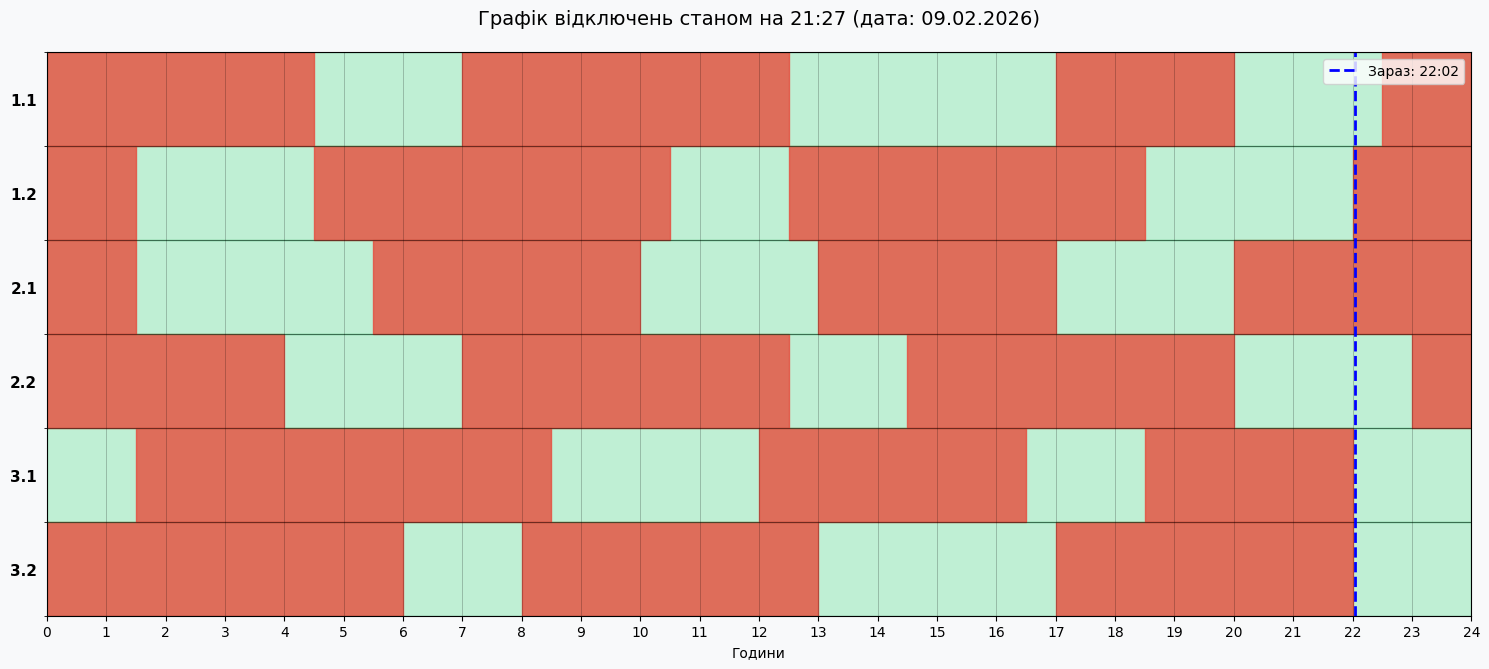

In [3]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime

def visualize_clean_grid(file_name, target_groups):
    # 1. Завантаження даних
    try:
        with open(file_name, 'r', encoding='utf-8') as f:
            all_content = json.load(f)
            # Дістаємо час оновлення та словник з графіками
            update_time = all_content.get("update_time", "Невідомо")
            all_data = all_content.get("schedules", {})
    except Exception as e:
        print(f"Помилка: {e}")
        return

    def time_to_float(t_str):
        h, m = map(int, t_str.split(':'))
        return h + m / 60.0

    # Фільтрація та сортування (1.1 зверху)
    display_groups = [g for g in sorted(target_groups, reverse=True) if g in all_data]
    
    if not display_groups:
        print("Групи не знайдені у файлі.")
        return

    # 2. Побудова графіка
    fig, ax = plt.subplots(figsize=(15, len(display_groups) * 0.8 + 2), facecolor='#f8f9fa')
    ax.set_facecolor('#ffffff')
    
    for i, group in enumerate(display_groups):
        # i - 0.5 та висота 1 роблять прямокутник рівно від однієї межі сітки до іншої
        ax.add_patch(patches.Rectangle((0, i - 0.5), 24, 1, color='#2ecc71', alpha=0.3))
        
        # Накладаємо червоні зони (відключення)
        for start_str, end_str in all_data[group]:
            start = time_to_float(start_str)
            end = time_to_float(end_str)
            ax.add_patch(patches.Rectangle((start, i - 0.5), end - start, 1, color='#e74c3c', alpha=0.8))

    # 3. НАЛАШТУВАННЯ СІТКИ (Табуляція без центральних ліній)
    ax.set_yticks(range(len(display_groups)))
    ax.set_yticklabels(display_groups, fontweight='bold', fontsize=11)
    ax.set_yticks([i - 0.5 for i in range(len(display_groups) + 1)], minor=True)
    ax.set_xticks(range(25))
    
    ax.grid(which='major', axis='x', color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.grid(which='minor', axis='y', color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.tick_params(axis='y', which='major', left=False) 

    # 4. Оформлення
    ax.set_xlim(0, 24)
    ax.set_ylim(-0.5, len(display_groups) - 0.5)
    
    # Лінія поточного часу
    now = datetime.now()
    current_time = now.hour + now.minute / 60.0
    ax.axvline(x=current_time, color='blue', linestyle='--', linewidth=2, label=f'Зараз: {now.strftime("%H:%M")}')

    # Додаємо час оновлення з JSON у заголовок
    plt.title(f"Графік відключень станом на {update_time} (дата: {datetime.now().strftime('%d.%m.%Y')})", fontsize=14, pad=20)
    ax.set_xlabel("Години")
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# --- ВИКОРИСТАННЯ ---
my_groups = ['1.1', '1.2', '2.1', '2.2', '3.1', '3.2'] 
visualize_clean_grid('schedule.json', my_groups)

### 3. Пошук спільних годин зі світлом (Intersection Analysis)
**Призначення:** Пошук ідеального часу для онлайн-зустрічей та спільної роботи.
* **Логіка:** Алгоритм аналізує графіки декількох обраних груп (наприклад, вашої та ваших колег) і знаходить перетин (інверсію) множин відключень.
* **Результат:** Скрипт виводить точні часові інтервали, коли світло буде одночасно у всіх учасників. Це дозволяє планувати конференції без ризику раптового зникнення зв'язку в одного з членів команди.

In [4]:
def find_common_power_on_slots(file_name, target_groups):
    # 1. Завантаження даних
    try:
        with open(file_name, 'r', encoding='utf-8') as f:
            all_content = json.load(f)
            # Дістаємо час оновлення та словник з графіками
            update_time = all_content.get("update_time", "Невідомо")
            all_data = all_content.get("schedules", {})
    except Exception as e:
        print(f"Помилка: {e}")
        return

    def time_to_min(t_str):
        h, m = map(int, t_str.split(':'))
        return h * 60 + m

    def min_to_time(m):
        return f"{int(m // 60):02d}:{int(m % 60):02d}"

    # 1. Перетворюємо "графіки відключень" у "графіки наявності світла" для кожної групи
    all_groups_on_minutes = []
    
    for group in target_groups:
        if group not in all_data: continue
        
        # Сортуємо інтервали відключень
        off_slots = sorted([(time_to_min(s), time_to_min(e)) for s, e in all_data[group]])
        
        # Вираховуємо інверсію (коли світло Є)
        on_slots = []
        last_end = 0
        for start, end in off_slots:
            if start > last_end:
                on_slots.append((last_end, start))
            last_end = max(last_end, end)
        if last_end < 1440: # до кінця доби (24:00)
            on_slots.append((last_end, 1440))
        
        all_groups_on_minutes.append(on_slots)

    if not all_groups_on_minutes:
        return "Дані для обраних груп відсутні."

    # 2. Знаходимо перетин (Intersection) усіх проміжків "on_slots"
    common_on = all_groups_on_minutes[0]
    
    for next_group_on in all_groups_on_minutes[1:]:
        new_intersection = []
        for s1, e1 in common_on:
            for s2, e2 in next_group_on:
                start = max(s1, s2)
                end = min(e1, e2)
                if start < end:
                    new_intersection.append((start, end))
        common_on = new_intersection

    # 3. Вивід результату
    print(f"--- 💡 Спільні години зі світлом для груп: {', '.join(target_groups)} ---")
    if not common_on:
        print("❌ На жаль, немає жодної спільної години зі світлом для всіх цих груп.")
    else:
        for s, e in common_on:
            duration = (e - s) / 60
            print(f"✅ {min_to_time(s)} — {min_to_time(e)} (тривалість: {duration:g} год)")

# --- ВИКОРИСТАННЯ ---
# Вкажіть групи ваших колег тут
colleagues_groups = ['1.1', '4.1', '6.1'] 
find_common_power_on_slots('schedule.json', colleagues_groups)

--- 💡 Спільні години зі світлом для груп: 1.1, 4.1, 6.1 ---
✅ 05:30 — 07:00 (тривалість: 1.5 год)
✅ 14:30 — 16:30 (тривалість: 2 год)


### 4. Статистичний аналіз та порівняльні показники
**Призначення:** Кількісна оцінка складності графіків для різних груп.
* **Технології:** `pandas`.
* **Аналітика:** Розрахунок ключових метрик для кожної групи:
    * **Сумарна кількість годин без світла:** Скільки часу триває дефіцит енергії за добу.
    * **Максимальна тривалість відключення:** Допомагає оцінити автономність (наприклад, для ДБЖ чи холодильників).
    * **Інтенсивність:** Відсоток доби, протягом якого електроенергія відсутня.
    * **Частота:** Кількість окремих циклів вимкнення/увімкнення.

In [5]:
import pandas as pd

def show_outage_statistics(file_name):
    # 1. Завантаження даних
    try:
        with open(file_name, 'r', encoding='utf-8') as f:
            all_content = json.load(f)
            # Дістаємо час оновлення та словник з графіками
            update_time = all_content.get("update_time", "Невідомо")
            all_data = all_content.get("schedules", {})
    except Exception as e:
        print(f"Помилка: {e}")
        return

    def time_to_float(t_str):
        h, m = map(int, t_str.split(':'))
        return h + m / 60.0

    stats = []

    for group, intervals in all_data.items():
        total_hours = 0
        durations = []
        
        for start_str, end_str in intervals:
            duration = time_to_float(end_str) - time_to_float(start_str)
            total_hours += duration
            durations.append(duration)
        
        stats.append({
            "Група": group,
            "К-сть відключень": len(intervals),
            "Загалом без світла (год)": round(total_hours, 1),
            "Макс. тривалість (год)": round(max(durations), 1) if durations else 0,
            "Середня тривалість (год)": round(total_hours / len(intervals), 1) if intervals else 0,
            "% доби без світла": f"{round((total_hours / 24) * 100)}%"
        })

    # 2. Створення DataFrame для красивого виводу
    df = pd.DataFrame(stats).sort_values(by="Група")
    
    print("=== Статистика відключень на сьогодні ===")
    return df

# Виклик статистики
stats_df = show_outage_statistics('schedule.json')
stats_df

=== Статистика відключень на сьогодні ===


,Група,К-сть відключень,Загалом без світла (год),Макс. тривалість (год),Середня тривалість (год),% доби без світла
0,1.1,4,14.5,5.5,3.6,60%
1,1.2,4,15.5,6.0,3.9,65%
2,2.1,4,14.0,4.5,3.5,58%
3,2.2,4,16.0,5.5,4.0,67%
4,3.1,3,15.0,7.0,5.0,62%
5,3.2,3,16.0,6.0,5.3,67%
6,4.1,3,17.5,6.0,5.8,73%
7,4.2,4,14.0,5.5,3.5,58%
8,5.1,4,14.5,6.0,3.6,60%
9,5.2,3,15.5,6.5,5.2,65%
